In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
data = pd.read_csv('/content/ALL_FAIL_LOG_VIBE_0_Random.csv')

In [ ]:
print("Dataset Shape:", data.shape)
print("\nColumns:\n", data.columns)
print("\nSample Data:\n", data.head())
print("\nMissing Values:\n", data.isnull().sum())

Dataset Shape: (4900, 9)

Columns:
 Index(['LineNo', 'TimeUS', 'IMU', 'VibeX', 'VibeY', 'VibeZ', 'Clip', 'labels',
       'labels.1'],
      dtype='object')

Sample Data:
    LineNo     TimeUS  IMU     VibeX     VibeY     VibeZ  Clip  labels  \
0  424709  503763414    0  0.120009  0.108398  0.148239     0       4   
1  426871  506163287    0  0.003210  0.003270  0.002992     0       4   
2  435120  516463332    0  0.002998  0.003317  0.002864     0       4   
3  145047  192963617    0  0.163687  0.116775  0.247265     0       0   
4  430951  511263746    0  0.002952  0.002766  0.002777     0       4   

   labels.1  
0         0  
1         0  
2         0  
3         0  
4         0  

Missing Values:
 LineNo      0
TimeUS      0
IMU         0
VibeX       0
VibeY       0
VibeZ       0
Clip        0
labels      0
labels.1    0
dtype: int64


In [ ]:
print("\nData Types:\n", data.dtypes)


Data Types:
 LineNo        int64
TimeUS        int64
IMU           int64
VibeX       float64
VibeY       float64
VibeZ       float64
Clip          int64
labels        int64
labels.1      int64
dtype: object



Label Distribution:
 labels
0    2462
4     753
1     609
2     594
3     482
Name: count, dtype: int64


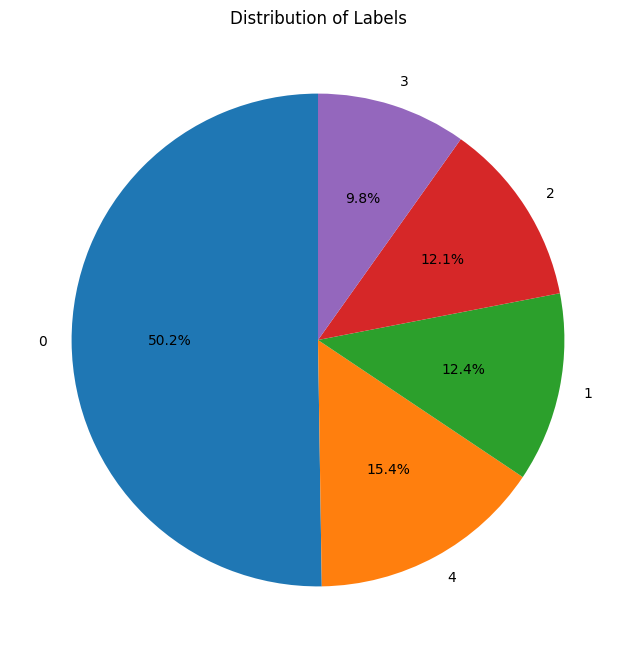

In [ ]:
if 'labels' in data.columns:
    label_counts = data['labels'].value_counts()
    print("\nLabel Distribution:\n", label_counts)
    plt.figure(figsize=(8, 8))
    plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', startangle=90)
    plt.title('Distribution of Labels')
    plt.show()

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
0    679
1    151
4    132
3     18
Name: count, dtype: int64


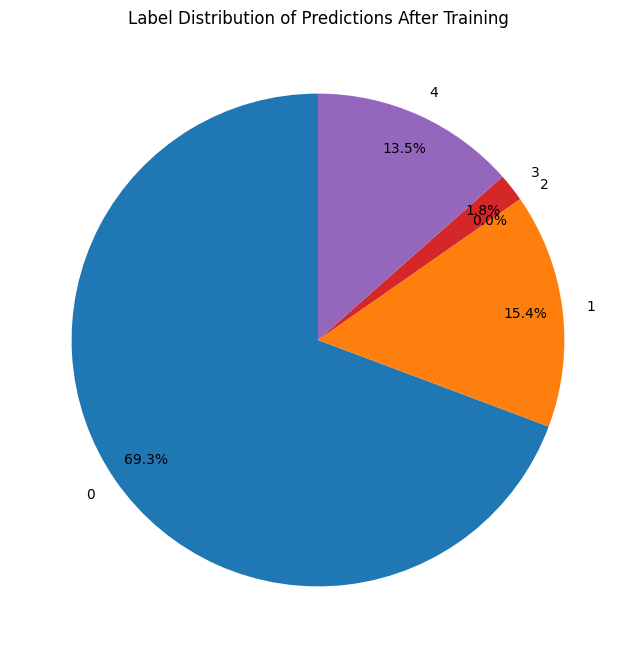

In [ ]:
# Get the predicted labels after training (from the last fold or the final model)
y_pred = model.predict(X_val_fold)
y_pred_classes = np.argmax(y_pred, axis=1)

# Count the occurrences of each predicted label
class_counts = pd.Series(y_pred_classes).value_counts()
print(class_counts)
# Ensure label_encoder.classes_ contains all possible labels, including those with zero counts
unique_labels = np.unique(y_pred_classes)

# Initialize a dictionary with zero counts for all labels
label_counts = {label: 0 for label in range(len(label_encoder.classes_))}

# Count the occurrences of each predicted label
for label in y_pred_classes:
    label_counts[label] += 1

# Create a list of counts and corresponding label names
counts = [label_counts[label] for label in range(len(label_encoder.classes_))]
label_names = label_encoder.classes_

# Plotting the pie chart for all predictions
plt.figure(figsize=(8, 8))
plt.pie(counts, labels=label_names, autopct='%1.1f%%', startangle=90, pctdistance=0.85, labeldistance=1.1)
plt.title('Label Distribution of Predictions After Training')
plt.show()


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv1D, BatchNormalization, Activation, Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import categorical_crossentropy
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
# Encoding Categorical Data
if 'labels' in data.columns:
    label_encoder = LabelEncoder()
    data['labels'] = label_encoder.fit_transform(data['labels'])
    print("\nLabel Encoding Complete. Classes:", label_encoder.classes_)


Label Encoding Complete. Classes: [0 1 2 3 4]


In [ ]:
# Feature Selection
X = data.drop(columns=['labels']).values  # Features
y = data['labels'].values  # Target

In [ ]:
# Scaling Features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
# One-hot encode the labels
y_encoded = to_categorical(y, num_classes=len(np.unique(y)))

In [ ]:
# Reshaping for TCN (samples, time_steps, features)
X_reshaped = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))

In [ ]:
# Define the TCN Block
def TCN_Block(filters, kernel_size, dilation_rate):
    return tf.keras.Sequential([
        Conv1D(filters=filters, kernel_size=kernel_size, padding='causal', dilation_rate=dilation_rate),
        BatchNormalization(),
        Activation('relu')
    ])

In [ ]:
# Define the Attention Layer
class AttentionLayer(tf.keras.layers.Layer):
    def __init__(self):
        super(AttentionLayer, self).__init__()

    def build(self, input_shape):
        self.W = self.add_weight(shape=(input_shape[-1], input_shape[-1]), initializer="glorot_uniform", trainable=True)
        self.b = self.add_weight(shape=(input_shape[-1],), initializer="zeros", trainable=True)
        self.u = self.add_weight(shape=(input_shape[-1],), initializer="glorot_uniform", trainable=True)

    def call(self, inputs):
        u_t = tf.tanh(tf.tensordot(inputs, self.W, axes=1) + self.b)
        a_t = tf.nn.softmax(tf.tensordot(u_t, self.u, axes=1), axis=1)
        output = tf.reduce_sum(inputs * tf.expand_dims(a_t, -1), axis=1)
        return output

In [ ]:
# Define the TCN with Attention Model
def build_tcn_attention_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)

    # TCN Layers
    x = TCN_Block(filters=64, kernel_size=3, dilation_rate=4)(inputs)
    x = TCN_Block(filters=64, kernel_size=3, dilation_rate=8)(x)
    x = TCN_Block(filters=64, kernel_size=3, dilation_rate=16)(x)

    # Attention mechanism
    attention_output = AttentionLayer()(x)

    # Classification
    classification = Dense(num_classes, activation='softmax')(attention_output)

    # Define and compile the model
    model = Model(inputs=inputs, outputs=classification)
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss=categorical_crossentropy,
                  metrics=['accuracy'])

    return model

In [ ]:
# Input shape for TCN
input_shape = (X_reshaped.shape[1], X_reshaped.shape[2])
num_classes = y_encoded.shape[1]

In [ ]:
# Perform k-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
fold_no = 1
accuracies = []
label_accuracies = []

for train_index, val_index in kf.split(X_reshaped):
    print(f"\nTraining fold {fold_no}...")

    # Split data
    X_train_fold, X_val_fold = X_reshaped[train_index], X_reshaped[val_index]
    y_train_fold, y_val_fold = y_encoded[train_index], y_encoded[val_index]

    # Build and train the model
    model = build_tcn_attention_model(input_shape, num_classes)
    model.fit(X_train_fold, y_train_fold, epochs=50, batch_size=32, verbose=1, validation_data=(X_val_fold, y_val_fold))

    # Evaluate the model
    loss, accuracy = model.evaluate(X_val_fold, y_val_fold, verbose=0)
    print(f"Validation Accuracy for fold {fold_no}: {accuracy:.4f}")
    accuracies.append(accuracy)

    # Predictions
    y_pred = model.predict(X_val_fold)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y_val_fold, axis=1)

    # Accuracy per label
    label_acc = []
    for label in range(num_classes):
        label_indices = (y_true_classes == label)
        label_acc.append(accuracy_score(y_true_classes[label_indices], y_pred_classes[label_indices]))
    label_accuracies.append(label_acc)

    fold_no += 1


Training fold 1...
Epoch 1/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 11s 32ms/step - accuracy: 0.6580 - loss: 0.9084 - val_accuracy: 0.5194 - val_loss: 1.1645
Epoch 2/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8250 - loss: 0.4236 - val_accuracy: 0.5204 - val_loss: 0.9641
Epoch 3/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8489 - loss: 0.3592 - val_accuracy: 0.7010 - val_loss: 0.6237
Epoch 4/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8645 - loss: 0.3285 - val_accuracy: 0.7561 - val_loss: 0.4923
Epoch 5/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8558 - loss: 0.3413 - val_accuracy: 0.7276 - val_loss: 0.4864
Epoch 6/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8475 - loss: 0.3427 - val_accuracy: 0.7459 - val_loss: 0.5200
Epoch 7/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8708 - loss: 0.3154 - val_accuracy: 0.7031 - val_loss: 0.5352
Epoch 8/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8610 - loss: 0.3

In [ ]:
# Calculate average accuracy
average_accuracy = np.mean(accuracies)
print(f"\nAverage Accuracy across all folds: {average_accuracy:.4f}")


Average Accuracy across all folds: 0.7516


In [ ]:
# Average accuracy per label
label_accuracies = np.mean(label_accuracies, axis=0)
for idx, acc in enumerate(label_accuracies):
    print(f"Label {idx} Accuracy: {acc:.4f}")

Label 0 Accuracy: 0.9127
Label 1 Accuracy: 0.9225
Label 2 Accuracy: 0.0193
Label 3 Accuracy: 0.2884
Label 4 Accuracy: 0.9643


In [ ]:
# Evaluate the last fold predictions
y_pred = model.predict(X_val_fold)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_val_fold, axis=1)

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


In [ ]:
# Classification report
print("\nClassification Report:\n")
print(classification_report(y_true_classes, y_pred_classes,digits = 4))


Classification Report:

              precision    recall  f1-score   support

           0     0.6583    0.9198    0.7674       486
           1     0.7417    0.8960    0.8116       125
           2     0.0000    0.0000    0.0000       125
           3     1.0000    0.1714    0.2927       105
           4     1.0000    0.9496    0.9742       139

    accuracy                         0.7235       980
   macro avg     0.6800    0.5874    0.5692       980
weighted avg     0.6701    0.7235    0.6536       980



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


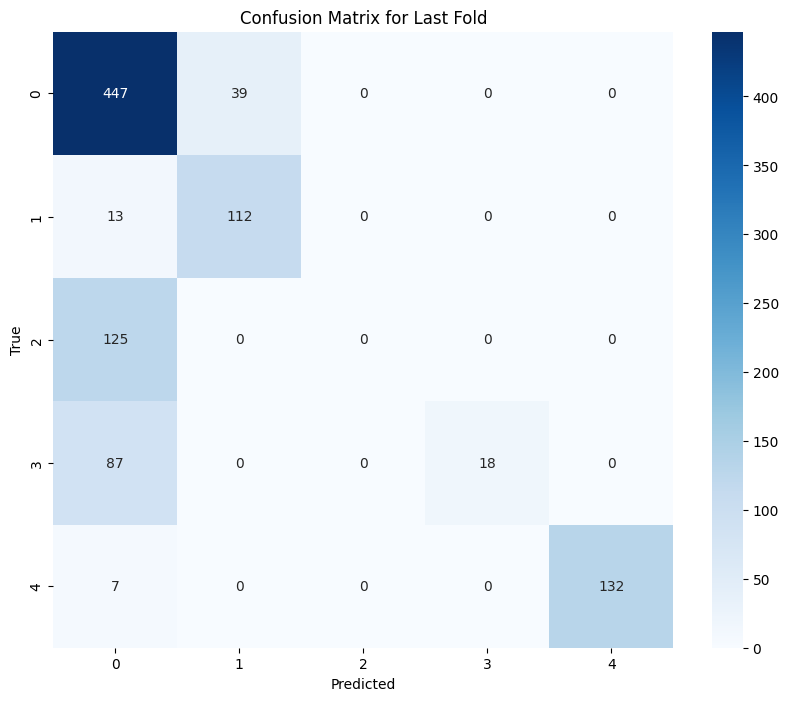

In [ ]:
# Confusion Matrix
conf_matrix = tf.math.confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for Last Fold')
plt.show()

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Distribution of predicted labels (entire dataset):
0    3395
1     755
4     660
3      90
Name: count, dtype: int64


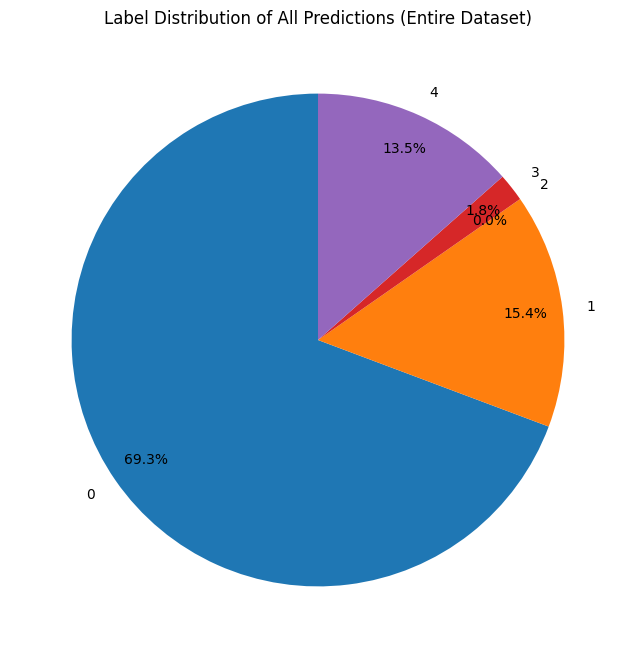

In [ ]:
# Create lists to collect predictions
all_y_pred = []
all_y_true = []

for train_index, val_index in kf.split(X_reshaped):
    # ... (training code for each fold remains the same)

    # Predictions from this fold
    y_pred = model.predict(X_val_fold)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y_val_fold, axis=1)

    # Append predictions and true labels for this fold
    all_y_pred.extend(y_pred_classes)
    all_y_true.extend(y_true_classes)

# After all folds are complete, you can now examine the distribution
all_y_pred = np.array(all_y_pred)
all_y_true = np.array(all_y_true)

# Distribution of predictions across all data
print("\nDistribution of predicted labels (entire dataset):")
print(pd.Series(all_y_pred).value_counts())

# Ensure label_encoder.classes_ contains all possible labels, including those with zero counts
unique_labels = np.unique(all_y_pred)

# Initialize a dictionary with zero counts for all labels
label_counts = {label: 0 for label in range(len(label_encoder.classes_))}

# Count the occurrences of each predicted label
for label in all_y_pred:
    label_counts[label] += 1

# Create a list of counts and corresponding label names
counts = [label_counts[label] for label in range(len(label_encoder.classes_))]
label_names = label_encoder.classes_

# Plotting the pie chart for all predictions
plt.figure(figsize=(8, 8))
plt.pie(counts, labels=label_names, autopct='%1.1f%%', startangle=90, pctdistance=0.85, labeldistance=1.1)
plt.title('Label Distribution of All Predictions (Entire Dataset)')
plt.show()
